# Convolution Neural Network for image classification

Problem Statement: This is an image classification problem. The task is to classify images as Cat or Dog, hence Binary classification.

Solution: This can be reloved using Deep Learning techniques. Lets try with Convolutional Neural Network with Augmentation

## Import Libraries

In [19]:
import os
from os import makedirs
from os import listdir
from shutil import copyfile
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout,Flatten, Conv2D,RandomContrast ,RandomFlip,RandomRotation, RandomZoom, RandomHeight, RandomWidth,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory

## Load Data
The Data is in zip file format, therefore unzip and load data into dataframes

In [20]:
os.listdir('./kaggle/input/dogs-vs-cats')

['sampleSubmission.csv', 'test1.zip', 'train.zip']

In [21]:
train_data = './kaggle/input/dogs-vs-cats/train.zip'
test_data = './kaggle/input/dogs-vs-cats/test1.zip'

files = './kaggle/working/'

import zipfile

with zipfile.ZipFile(train_data,'r') as zipp:
    zipp.extractall(files)

with zipfile.ZipFile(test_data,'r') as zipp:
    zipp.extractall(files)

In [22]:
os.listdir('./kaggle/working')

['test1', 'train']

## Splitting

Splitting the name for files and creating a target label as Dog or Cat

In [23]:
filenames = os.listdir('./kaggle/working/train/')
labels = [file_name.split(".")[0] for file_name in filenames]

In [24]:
df_train = pd.DataFrame({'Filenames':filenames,'Label':labels})
df_train.head(5)

,Filenames,Label
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


## Sample
Taking only 2000 images as data is huge

In [7]:
df_train = df_train.iloc[:2000,:]
df_train_copy =  df_train.iloc[:2000,:]

## Target Balance
The Balance is more or less 50% each, hence its good for modeling

In [8]:
df_train['Label'].value_counts()

Label
cat    2000
Name: count, dtype: int64

## Load Test Data Set

In [9]:
filenames = os.listdir('./kaggle/working/test1')
labels = [file_name.split(".")[0] for file_name in filenames]

In [10]:
df_test = pd.DataFrame({'Filenames':filenames,'Label':labels})
df_test.head(5)

,Filenames,Label
0,1.jpg,1
1,10.jpg,10
2,100.jpg,100
3,1000.jpg,1000
4,10000.jpg,10000


## Visualize Sample Images

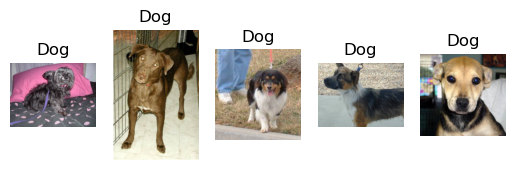

In [11]:
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.title('Cat')
    filename = './kaggle/working/train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog')
    filename = './kaggle/working/train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)    
    plt.axis('off')

## Train Test Split Data

Here we use Y not as an array but as labeling the class using stratify.

From Sklearn, stratify : array-like, default=None, If not None, data is split in a stratified fashion, using this as the class labels

In [12]:
X= df_train['Filenames']
y= df_train['Label']
X_train,X_Val = train_test_split(df_train,stratify=y,test_size=0.2,random_state=42)

## Generate Images

Keras ImageDataGenerator is a very powerful library which not only helps in image generation but also image augumentation

In [13]:
train_dg = ImageDataGenerator(rescale = 1./255)
validate_dg = ImageDataGenerator(rescale = 1./255)

## Define images generated in Train, Validate and Test

In [14]:
train_g = train_dg.flow_from_dataframe(dataframe = X_train,directory='./kaggle/working/train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       #class_mode='binary',
                                       target_size=(128,128),batch_size=32)
validate_g = validate_dg.flow_from_dataframe(dataframe = X_Val,directory='./kaggle/working/train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       #class_mode='binary',
                                       target_size=(128,128),batch_size=32,shuffle=False)
test_g = validate_dg.flow_from_dataframe(dataframe = df_test,directory='./kaggle/working/test1/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,class_mode=None,
                                       target_size=(128,128),batch_size=32,
                                       shuffle=False)

Found 1600 validated image filenames belonging to 1 classes.
Found 400 validated image filenames belonging to 1 classes.
Found 12500 validated image filenames.


## Model 1

Adding Augmentation Layer within CNN Model from layers

## Visualize different Image Augmentation

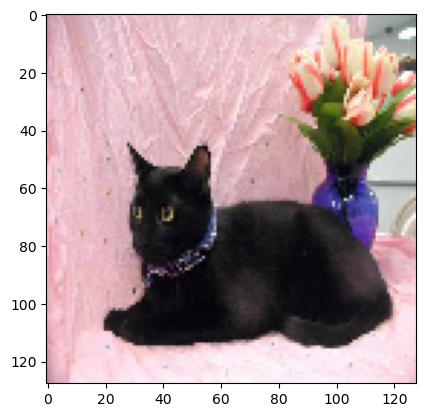

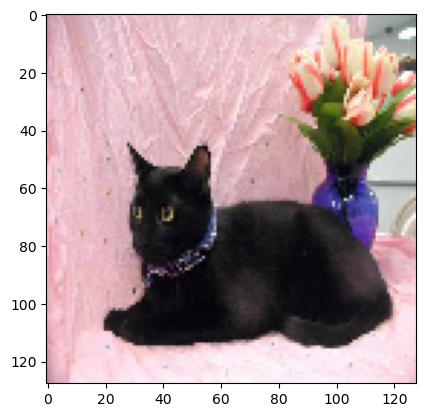

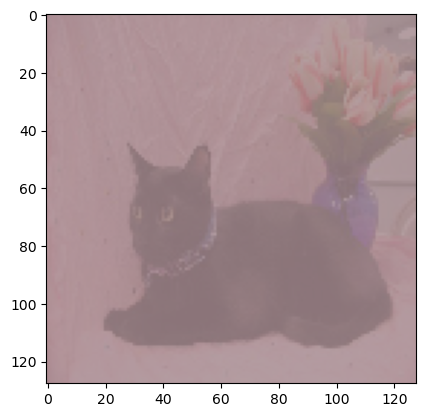

In [15]:
images, labels = next(train_g)
img = images[2]
plt.imshow(img)
plt.show()

random_flip = RandomFlip("horizontal_and_vertical")
flipped_image = random_flip(img)
plt.imshow(flipped_image)
plt.show()

random_contrast = RandomContrast(factor=0.90)
image_contrast = random_contrast(img)
plt.imshow(image_contrast)
plt.show()

### Define Layers

In [16]:
cnn_model = Sequential()

# Input Layer
cnn_model.add(Conv2D(32,kernel_size=(3,3),activation = 'relu'
                     ,input_shape=(128,128,3)))
cnn_model.add(MaxPooling2D(2,2))

# Augumentation Layer
cnn_model.add(RandomRotation(0.2))
cnn_model.add(RandomZoom(0.2))
cnn_model.add(RandomFlip("horizontal_and_vertical"))
cnn_model.add(RandomContrast(factor=0.90))

# Hidden Layers
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(254,kernel_size=(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

# Output Layer
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dense(512,activation='relu'))
cnn_model.add(Dense(2,activation='softmax'))

cnn_model.summary()

C:\Users\arvenka\AppData\Local\anaconda3\envs\tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 63, 63, 32)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 63, 63, 32)     │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 254)    │       292,862 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 254)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 254)      │         1,016 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,682,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,071,288 (19.35 MB)

 Trainable params: 5,070,332 (19.34 MB)

 Non-trainable params: 956 (3.73 KB)

### Compile

In [17]:
cnn_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### Callback

In [18]:
early_stoping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True,verbose=0)

### Fit

In [51]:
history = cnn_model.fit(train_g,epochs=20,validation_data=validate_g,batch_size = 32,callbacks=[early_stoping])

Epoch 1/20


C:\Users\arvenka\AppData\Local\anaconda3\envs\tensorflow\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - accuracy: 0.9110 - loss: 0.3990 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.9998 - loss: 1.4937e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 1.0000 - loss: 1.7002e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 0.9999 - loss: 1.5048e-04 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - accuracy: 0.9998 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.9995 - loss: 4.8340e-04 - val_accuracy: 1.0000 - val_loss: 3.8743e-09


### Train Accuracy

In [52]:
loss,accuracy = cnn_model.evaluate(train_g,batch_size = 32, verbose = 0)
loss,accuracy 

(0.0, 1.0)

### Prediction

In [53]:
pred = cnn_model.predict(validate_g,batch_size = 32)
y_pred = np.argmax(pred,axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


## Model 2

Using ImageGenerator to Augment Images

### Different Types Image Augmenation

### 1. Flip

In [57]:
img_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

batch = img_gen.flow_from_dataframe(dataframe = X_train,directory='./kaggle/working/train/',
                                       x_col ='Filenames',y_col='Label',
                                       has_ext =True,seed=42,
                                       class_mode='binary',
                                       target_size=(224,224),batch_size=1)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,8))

for i in range(3):
    
    # convert to unsigned integers 
    image_batch, label_batch = next(batch)
    image = image_batch[0].astype('uint8')
   
    ax[i].imshow(image)
    ax[i].axis('off')

ValueError: If class_mode="binary" there must be 2 classes. Found 1 classes.